# Continuous Control

---
### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, let's load the environment:

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Training by PPO with GAE

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import namedtuple

from PPO_Agent import PPOAgent

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Hyperparmeters
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = brain.vector_observation_space_size

n_episodes = 300
max_steps = 1000
reward_threshold = 30.
lr = 1e-4
batch_size = 64
opt_epoch = 5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

agent_ppo = PPOAgent(state_size, action_size, hidden_layers = [128, 64])

total_scores = []

episodes_bar = tqdm(total=n_episodes, desc='Episodes')

for i_episode in range(n_episodes):
    # collect trajectories
    trajectories, episode_score = agent_ppo.collect_trajectories(env, brain_name)
    total_scores.append(episode_score)
    
    # training using the collected trajectories, repeat 5 times
    agent_ppo.update(trajectories)
   
    # Calculate average score and print stats
    average_score = np.mean(total_scores[-100:])
    if i_episode % 20 == 0:
        print(f'Episode {i_episode}/{n_episodes} | Average Total Rewards Over Past 100 Episodes: {round(average_score, 2)}')
    if average_score >= reward_threshold:
        print(f'Environment solved in {i_episode}!')
        torch.save(agent_ppo.model.state_dict(), 'trained_with_PPO.pth')
        break
      
    episodes_bar.update(1)
    
episodes_bar.close()

Episode 0/300 | Average Total Rewards Over Past 100 Episodes: 0.65
Episode 20/300 | Average Total Rewards Over Past 100 Episodes: 1.94
Episode 40/300 | Average Total Rewards Over Past 100 Episodes: 3.87
Episode 60/300 | Average Total Rewards Over Past 100 Episodes: 5.79
Episode 80/300 | Average Total Rewards Over Past 100 Episodes: 7.6
Episode 100/300 | Average Total Rewards Over Past 100 Episodes: 9.32
Episode 120/300 | Average Total Rewards Over Past 100 Episodes: 12.69
Episode 140/300 | Average Total Rewards Over Past 100 Episodes: 15.97
Episode 160/300 | Average Total Rewards Over Past 100 Episodes: 19.51
Episode 180/300 | Average Total Rewards Over Past 100 Episodes: 22.96
Episode 200/300 | Average Total Rewards Over Past 100 Episodes: 26.13
Episode 220/300 | Average Total Rewards Over Past 100 Episodes: 28.82
Environment solved in 230!



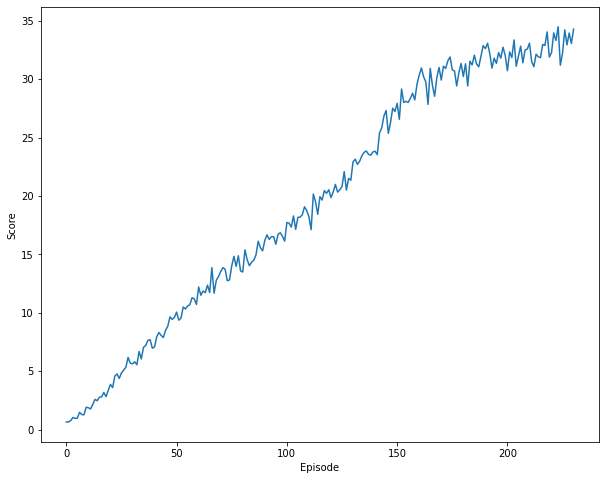

In [6]:
plt.figure(figsize=(10, 8))
plt.plot(total_scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.savefig('reward_plot_PPO.png', dpi=300, bbox_inches='tight')
plt.show()

Close the environment when finished.

In [7]:
env.close()